# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *R*

**Names:**

* *Raphael Barman*
* *Thierry Bossy*
* *Raphael Strebel*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [83]:
import epidemics_helper
import json
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

In [3]:
# Load the data of nyc network
with open('../data/nyc_augmented_network.json') as data_file:    
    data = json.load(data_file)
    
graph = nx.Graph()

nb_edges = len(data['links']) - 1

# Construct the graph edge by edge (there has to be a nicer way)
for i in range(0, nb_edges):
    graph.add_edge(data['links'][i]['source'], data['links'][i]['target'])

print("Number of nodes:", nx.number_of_nodes(graph))
print("Number of edges:", nb_edges)

Number of nodes: 26481
Number of edges: 43436


In [119]:
# Build the continuous-time SIR epidemic
sir = epidemics_helper.SimulationSIR(graph, beta=10.0, gamma=0.1)

# Launch epidemic
sir.launch_epidemic(source=23654, max_time=100.0)

Epidemic stopped after 111.10 days | 111.10 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered


In [120]:
nb_nodes = nx.number_of_nodes(graph)
def percentage_recovered(t):
    return len([x for x in sir.rec_time if x < t])/nb_nodes
def percentage_infected(t):
    return len([x for x in sir.inf_time if x < t])/nb_nodes-percentage_recovered(t)
def percentage_susceptible(t):
    return 1-percentage_infected(t)-percentage_recovered(t)

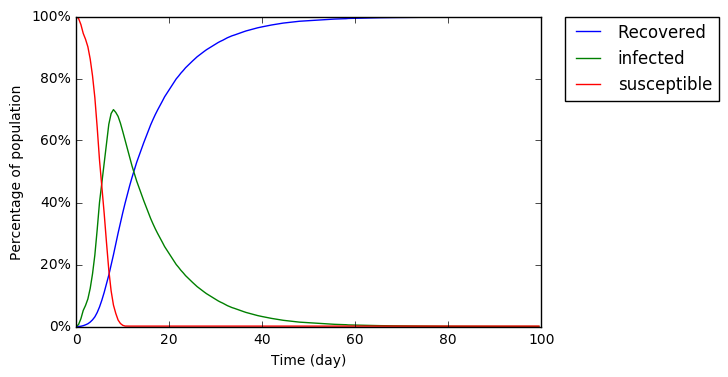

In [121]:
time = np.arange(0.0,100.0,0.5)
ax = plt.subplot(1,1,1)
ax.plot(time,np.vectorize(percentage_recovered)(time),label="Recovered")
ax.plot(time,np.vectorize(percentage_infected)(time), label="infected")
ax.plot(time,np.vectorize(percentage_susceptible)(time), label="susceptible")
ax.set_xlabel('Time (day)')
ax.set_ylabel('Percentage of population')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
def pct(x,pos): return "{}%".format(int(x*100))
ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))

In [141]:
def bisection(f, low, high, eps=0.001):
    mid = (low+high)/2.0
    if f(mid)==0 or (high-low)/2.0 < eps:
        return mid
    else:
        if f(mid)*f(low) > 0:
            return bisection(f,mid,high,eps)
        else:
            return bisection(f,low,mid,eps)

In [145]:
print("It takes %.2f"% (bisection((lambda t:percentage_infected(t)-0.6),0,20)), "days to have 60% of the population infected.")
print("It takes %.2f"% (bisection((lambda t:percentage_recovered(t)-0.6),0,40)), "days to have 60% of the population dead.")

It takes 6.57 days to have 60% of the population infected.
It takes 14.70 days to have 60% of the population dead.


---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [8]:
import random as rand

In [9]:
# Build the continuous-time SIR epidemic
sir = epidemics_helper.SimulationSIR(graph, beta=10.0, gamma=0.1)

# Remove edges at random
edges_to_remove = 1000
randomSample = rand.sample(graph.edges(), edges_to_remove)
graph.remove_edges_from(randomSample)

# Launch epidemic
sir.launch_epidemic(source=rand.randint(0, nb_nodes - 1), max_time=100.0)

Epidemic stopped after 109.41 days | 109.41 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered


No, this strategy is not very effective since we remove edges between nodes that might not be infected instead of removing edges between nodes that will be infected with high probability.

In [10]:
# Hypothesis: at time 0-eps, ALL edges are healthy
nb_inf = 0
nb_rec = 0
nb_healthy = nb_nodes

# Count the nodes that are infected or recovered after 30 days
for i in range(0, nb_nodes - 1):
    if(sir.inf_time[i] < 30):
        nb_inf += 1
        nb_healthy -= 1
    elif(sir.rec_time[i] < 30):
        nb_rec += 1
        nb_healthy -= 1

print("Number of healthy people after 30 days:", nb_healthy)
print("Number of infected people after 30 days:", nb_inf)
print("Number of dead people after 30 days:", nb_rec)

Number of healthy people after 30 days: 88
Number of infected people after 30 days: 26393
Number of dead people after 30 days: 0


In [11]:
# We remove 9000 additional random edges
edges_to_remove = 9000
randomSample = rand.sample(graph.edges(), edges_to_remove)
graph.remove_edges_from(randomSample)

# Launch epidemic
sir.launch_epidemic(source=rand.randint(0, nb_nodes - 1), max_time=100.0)

Epidemic stopped after 92.75 days | 92.75 days elapsed | 24.6% susceptible, 0.0% infected, 75.4% recovered


When removing 10000 edges, there are about 10% (wild guess) more healthy people than after removing 1000 edges.

#### Exercise 2.11: Strategy 2

KeyboardInterrupt: 

In [14]:
# algorithm: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4372451/
# compute edge centrality of all edges:
# increment by one all edges in shortest paths from n1 to n2 (using x.all_shortest_paths(graph, n1, n2))
# divide all elements in centrality by number of shortest paths from n1 to n2 (edge centrality is a fraction)
# do this for all pair of nodes, add centrality fractions to itself at each iteration of the loop
# delete the 2500 edges with highest centrality
# there must be a faster way to do this than a third for-loop

# Consider only giant component
giant_comp = max(nx.connected_component_subgraphs(graph), key=nx.number_of_nodes)

# Construct dictionary (edge): index 
index_edges = {}
for e in range(0, nx.number_of_edges(graph)):
    index_edges[graph.edges()[e]] = e
    
# Initialize edge centrality
centrality = [0]*nx.number_of_edges(giant_comp)
#for e in graph.edges():
#    centrality[e] = 0
    
# TODO might be able to replace this by nx.shortest_paths(graph) and putting centrality as edge weight
# Il faudrait un dictionnaire index - edge
# Compute edge centrality 
for n1 in giant_comp.nodes():
    # Initialize all edge appearences in shortest path to 0
    nb_edge_appearence = [0]*nx.number_of_edges(giant_comp)
        
    for n2 in giant_comp.nodes():
        if(n1 != n2):
            # for all edges we check if they appear in a shortest path
            for e in nx.number_of_edges(giant_comp):
                # Compute list of shortest paths from n1 to n2
                shortest_paths = nx.all_shortest_paths(giant_comp, n1, n2) 
                if(e in shortest_paths):
                    nb_edge_appearence[e] += 1
    
    # Get fraction of centralities            
    edge_centrality = nb_edge_appearence / len(shortest_paths) 
    centrality += edge_centrality

print(centrality)
# Delete edges with highest centrality 
nb_edges_to_delete = 2500
# Need to get indices of 2500 highest centralities
#[i for i, j in enumerate(centrality) if j == max(centrality)]

KeyboardInterrupt: 